# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
offer = pd.read_json('data/portfolio.json', orient='records', lines=True)
people = pd.read_json('data/profile.json', orient='records', lines=True)
record = pd.read_json('data/transcript.json', orient='records', lines=True)

#  1. Data Preprocessing and Feature Engineering

## 1. data preview

In [2]:
offer.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [3]:
people.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [4]:
record.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


## 2. data propoessing and wrangling

offer table: release channels into categorical columns

In [5]:
offer.channels.max()

['web', 'email', 'mobile', 'social']

In [6]:
offer['web'] = offer['channels'].apply(lambda x: 1 if 'web' in x else 0)
offer['email'] = offer['channels'].apply(lambda x: 1 if 'email' in x else 0)
offer['mobile'] = offer['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
offer['social'] = offer['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [7]:
offer.drop(['channels'], axis=1, inplace=True)
offer.rename(columns={'id':'offer_id'}, inplace=True)

In [8]:
offer.head(2)

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1


In [9]:
offer.dtypes

reward         int64
difficulty     int64
duration       int64
offer_type    object
offer_id      object
web            int64
email          int64
mobile         int64
social         int64
dtype: object

people table: get customer tenure (in months)

In [10]:
people['start_date'] = people['became_member_on'].astype(str).apply(lambda x : pd.to_datetime(x, infer_datetime_format=True))
people['cust_tenure'] = people['start_date'].apply(lambda x: round((pd.to_datetime('2023-02-21') - x)/np.timedelta64(1, 'M')),1)

In [11]:
people.drop(['became_member_on'], axis=1, inplace=True)
people.rename(columns={'id':'person_id'}, inplace=True)

In [12]:
people.head(2)

,gender,age,person_id,income,start_date,cust_tenure
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,72
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,67


In [13]:
#missing rate of 'income'
people[people.income.isna()==True].shape[0]/people.income.shape[0]

0.12794117647058822

In [ ]:
#fillna with mean
income_mean = main[main['income'].notna()]['income'].mean()
main['income'].fillna(value = income_mean, inplace=True)

66158.1304732064

In [14]:
people.dtypes

gender                 object
age                     int64
person_id              object
income                float64
start_date     datetime64[ns]
cust_tenure             int64
dtype: object

record table: release offer_id into columns

In [15]:
record['offer_id'] = record['value'].apply(lambda x: x['offer id'] if 'offer id' in x.keys()  else np.nan)
record['trxn_amt'] = record['value'].apply(lambda x: x['amount'] if 'amount' in x.keys()  else np.nan)

In [16]:
record.drop(['value'], axis=1, inplace=True)
record.rename(columns={'person':'person_id'}, inplace=True)

## 3. generate main table:
    - record_m table: record table + 'if_viewed', 'if_completed'
        - if_viewed: 1 if this client viewed offer, 0 if not
        - if_completed: 1 if this offer_id come with a 'offer_completed' event, 0 elsewise
        - if_valid: if this completed offer is drived by offer: = if_viewed & if_completed, and t_view < t_trxn
    - main: big table, record_m table joined with offer and person infomation
       
       

#### 1. Link offer_id to 'offer_complete' record

In [17]:
record_p = record.groupby('person_id').apply(lambda x: x.sort_values('time', ascending=True))

In [18]:
record_p.columns

Index(['person_id', 'event', 'time', 'offer_id', 'trxn_amt'], dtype='object')

In [19]:
record_p.index.names

FrozenList(['person_id', None])

In [20]:
record_p.index = record_p.index.droplevel(level=1)

In [21]:
#fill offer_id
df_fill = record_p[record_p['event'].isin(['offer received','offer completed'])]
df_rest = record_p[~record_p['event'].isin(['offer received','offer completed'])]

df_filled = df_fill.ffill()
record_f = pd.concat([df_filled, df_rest], axis=0)

In [22]:
record_f = record_f.reset_index(drop=True)
record_f = record_f.sort_values(['person_id','time'], ascending=True)

#### 2. create record_m table

In [23]:
record_f.head(2)

,person_id,event,time,offer_id,trxn_amt
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN
109856,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN


In [24]:
base = record_f[record_f['event']=='offer received'][['person_id','time','offer_id']].set_index(['person_id','offer_id'])

view = record_f[record_f['event']=='offer viewed'][['person_id','time','offer_id']].set_index(['person_id','offer_id'])

completed = record_f[record_f['event']=='offer completed'][['person_id','time','offer_id']].set_index(['person_id','offer_id'])

In [25]:
record_m_raw = base.join(view, how='left', lsuffix='_rcv',rsuffix='_view').join(completed, how='left')

In [26]:
record_m_raw.rename(columns={'time':'time_cplt'},inplace=True)

In [27]:
record_m_raw = record_m_raw.reset_index()

In [28]:
#add col: if view --> 1 viewed, 0 elsewise
record_m_raw['if_view'] = record_m_raw['time_view'].notna().apply(int)

In [29]:
#add col: if complete --> 1 completed offer, 0 elsewise
record_m_raw['if_complete'] = record_m_raw['time_cplt'].notna().apply(int)

In [30]:
#add col: if_valid --> 1: the completed offer is valid, meaing the person viewed the offer before complete it, 0 elsewise
record_m_raw['if_valid'] =  record_m_raw.apply(lambda x: 1 if x['if_complete']==1 and x['if_view']==1 and x['time_view']<=x['time_cplt'] else 0, axis=1)

In [31]:
#get record_m table
record_m = record_m_raw.drop_duplicates()

#### 3. attach offer detail, person detail

In [32]:
main = record_m.merge(people, on='person_id', how='left').merge(offer, on='offer_id', how='left')

In [33]:
main.head(10)

,person_id,offer_id,time_rcv,time_view,time_cplt,if_view,if_complete,if_valid,gender,age,...,start_date,cust_tenure,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,0,1,0,M,33,...,2017-04-21,70,2,10,7,discount,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,1,0,0,M,33,...,2017-04-21,70,0,0,4,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,NaN,1,0,0,M,33,...,2017-04-21,70,0,0,3,informational,0,1,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,1,1,0,M,33,...,2017-04-21,70,5,5,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,1,1,0,M,33,...,2017-04-21,70,2,10,10,discount,1,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0,NaN,1,0,0,None,118,...,2018-04-25,58,5,5,5,bogo,1,1,1,1
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,630.0,NaN,1,0,0,None,118,...,2018-04-25,58,5,5,5,bogo,1,1,1,1
7,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,216.0,NaN,1,0,0,None,118,...,2018-04-25,58,5,5,5,bogo,1,1,1,1
8,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0,NaN,1,0,0,None,118,...,2018-04-25,58,5,5,5,bogo,1,1,1,1
9,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,432.0,NaN,1,0,0,O,40,...,2018-01-09,61,5,20,10,discount,1,1,0,0


# 2. EDA
have some insights of the data

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
sns.set(style = 'whitegrid')

    - clean gender

In [36]:
# treat 'O' as a thrid type, fillna with 'O'
main.gender.value_counts(dropna=False)


M       55724
F       42453
None    12755
O        1399
Name: gender, dtype: int64

In [37]:
main['gender'].fillna(value = 'O', inplace=True)

#### 1. see the response rate by gender & offer_type

In [38]:
resp_1 = main.groupby(['gender', 'offer_type']).agg({'if_view':['mean','count'],'if_complete':['mean','count'],'if_valid':['mean','count']})

In [39]:
resp_1.columns = ['_'.join(col) for col in resp_1.columns.values]

In [40]:
resp_1 = resp_1.reset_index()

In [41]:
resp_1

,gender,offer_type,if_view_mean,if_view_count,if_complete_mean,if_complete_count,if_valid_mean,if_valid_count
0,F,bogo,0.913801,18318,0.773665,18318,0.513375,18318
1,F,discount,0.827095,17420,0.769059,17420,0.493858,17420
2,F,informational,0.795681,6715,0.111095,6715,0.062695,6715
3,M,bogo,0.902886,23385,0.617490,23385,0.413171,23385
4,M,discount,0.803779,23025,0.648817,23025,0.438350,23025
5,M,informational,0.789886,9314,0.102856,9314,0.064204,9314
6,O,bogo,0.918525,5830,0.218182,5830,0.154031,5830
7,O,discount,0.851937,5680,0.281690,5680,0.215317,5680
8,O,informational,0.844554,2644,0.065431,2644,0.040091,2644


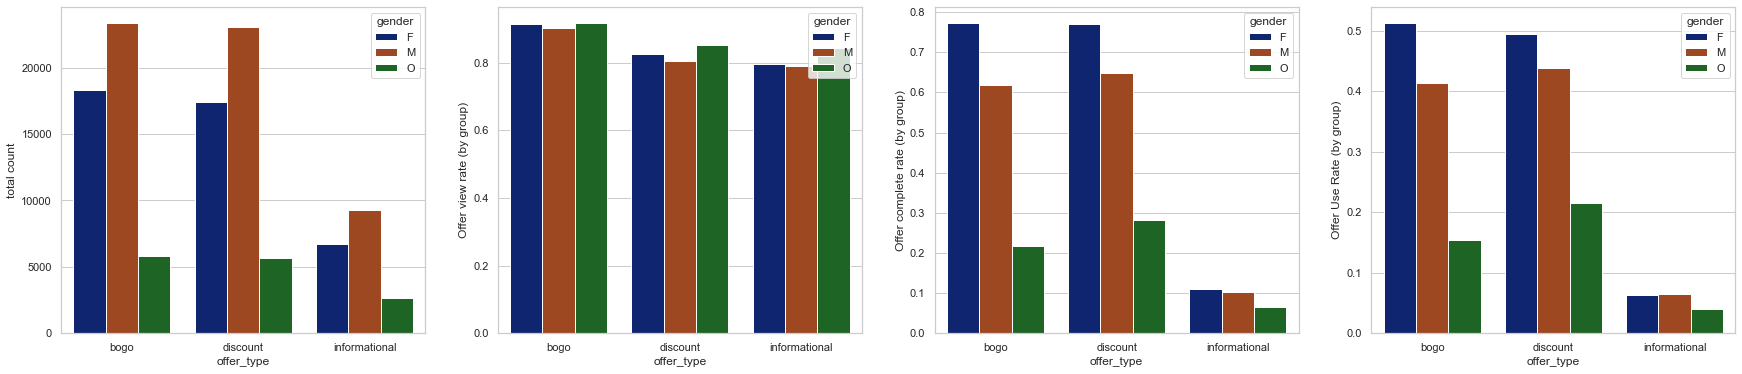

In [42]:
fig, axes = plt.subplots(1,4)
fig.set_size_inches(30, 6)

g0 = sns.barplot(
    data = resp_1,
    x='offer_type', y = 'if_valid_count', hue='gender',
    errorbar = 'sd', palette = 'dark', ax=axes[0]
)
g0.set_ylabel('total count')



g1 = sns.barplot(
    data = resp_1, 
    x='offer_type', y = 'if_view_mean', hue='gender',
    errorbar = 'sd', palette = 'dark', ax=axes[1]
)
g1.set_ylabel('Offer view rate (by group)')


g2 = sns.barplot(
    data = resp_1, 
    x='offer_type', y = 'if_complete_mean', hue='gender',
    errorbar = 'sd', palette = 'dark', ax=axes[2]
)
g2.set_ylabel('Offer complete rate (by group)')


g3 = sns.barplot(
    data = resp_1, 
    x='offer_type', y = 'if_valid_mean', hue='gender',
    errorbar = 'sd', palette = 'dark', ax=axes[3]
)
g3.set_ylabel('Offer Use Rate (by group)')



plt.savefig('respond_rate.png', dpi=300)

Observation 1: Gender Matters. Although there are more total offer sent to male among all offer types, female respond to offer more actively: female has higher rate of viewing offer, completing offer (w/w.o viewing offer), and valid offer consumption (transaction after viewing offer). 

Observation 2: Offer Type Matters. People will view informational offer, but they tend to not respond. 

Observation 3: For all gender, Offer use rate is lower than offer complete rate, by around 20%.  This means there are quite many people will make transaction even without knowing there's an offer. This justifies the practice to exclude them from offer send list. 

#### 2. How does channel affects

In [43]:
main.head(5)

,person_id,offer_id,time_rcv,time_view,time_cplt,if_view,if_complete,if_valid,gender,age,...,start_date,cust_tenure,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,0,1,0,M,33,...,2017-04-21,70,2,10,7,discount,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,1,0,0,M,33,...,2017-04-21,70,0,0,4,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,NaN,1,0,0,M,33,...,2017-04-21,70,0,0,3,informational,0,1,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,414.0,1,1,0,M,33,...,2017-04-21,70,5,5,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,528.0,1,1,0,M,33,...,2017-04-21,70,2,10,10,discount,1,1,1,1


In [44]:
#see channels vs offer_type
def show_dist_per_type(type):
    """
    show each offer type, the distribution of channels offers are sent
    """
    main_type = main[main.offer_type == type]
    main_type.loc[:,'label'] = main_type['web'].astype(str) + main_type['email'].astype(str) + main_type['mobile'].astype(str) + main_type['social'].astype(str)
    dist_type = main_type.groupby('label').agg({'if_view':'mean','if_complete':'mean','if_valid':'mean','offer_type':'count'})

    return dist_type
    

In [45]:
bogo_dist = show_dist_per_type('bogo')
discount_dist = show_dist_per_type('discount')
info_dist = show_dist_per_type('informational')

C:\Users\201705\AppData\Local\Temp\ipykernel_12800\3983808445.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_type.loc[:,'label'] = main_type['web'].astype(str) + main_type['email'].astype(str) + main_type['mobile'].astype(str) + main_type['social'].astype(str)
C:\Users\201705\AppData\Local\Temp\ipykernel_12800\3983808445.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_type.loc[:,'label'] = main_type['web'].astype(str) + main_type['email'].astype(str) + main_type['mobile'].astype(str) + ma

In [46]:
print(bogo_dist)

        if_view  if_complete  if_valid  offer_type
label                                             
0111   0.940053     0.602218  0.399616       11994
1110   0.697536     0.641556  0.352025       10593
1111   0.983885     0.635974  0.458671       24946


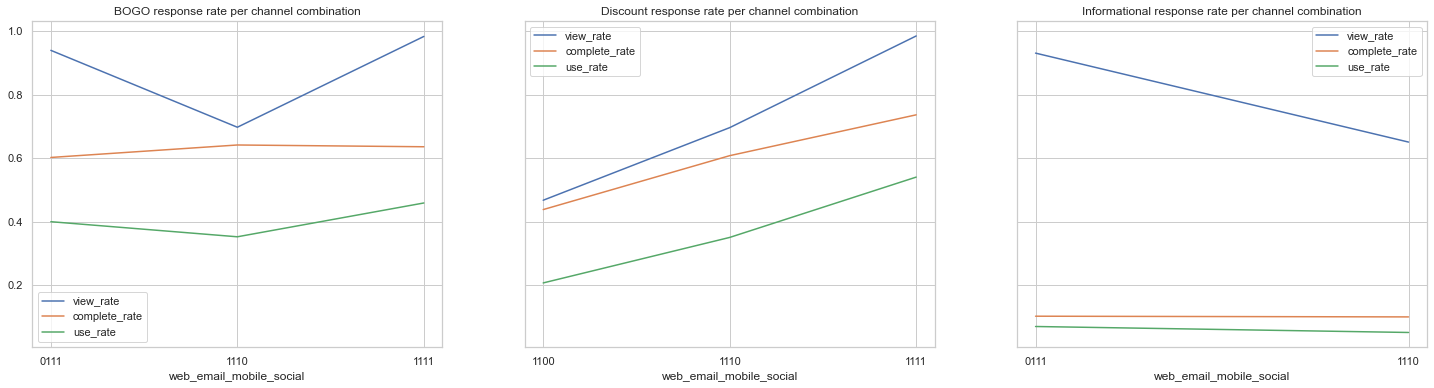

In [47]:
fig, axes = plt.subplots(1,3, sharey = True)
fig.set_size_inches(25, 6)
axes[0].plot(bogo_dist.index, bogo_dist[['if_view','if_complete','if_valid']])
axes[0].legend(['view_rate','complete_rate','use_rate'])
axes[0].set_title('BOGO response rate per channel combination')
axes[0].set_xlabel('web_email_mobile_social')

axes[1].plot(discount_dist.index, discount_dist[['if_view','if_complete','if_valid']])
axes[1].legend(['view_rate','complete_rate','use_rate'])
axes[1].set_title('Discount response rate per channel combination')
axes[1].set_xlabel('web_email_mobile_social')

axes[2].plot(info_dist.index, info_dist[['if_view','if_complete','if_valid']])
axes[2].legend(['view_rate','complete_rate','use_rate'])
axes[2].set_title('Informational response rate per channel combination')
axes[2].set_xlabel('web_email_mobile_social')

plt.savefig('response_by_channel.png',dpi = 300)

Observation 4: it seems for offer type BOGO and Information, the channel doesn't matter. For Discount type, people tend to repond more actively when number of channels increase.

#### 3. Check factors: is there any trend with age, cust_tenure
    - 1. age need to be cleaned--> [0-100] is valid value

<AxesSubplot:>

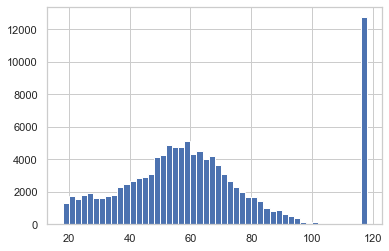

In [48]:
main.age.hist(bins=50)

In [49]:
#age: fill na and age> 110 with mean value
age_mean = main[main['age']<110]['age'].mean()
main['age'].fillna(value = age_mean, inplace=True)
main.loc[main.age>110, 'age'] = age_mean

    - 2. check cust_tenure

<AxesSubplot:>

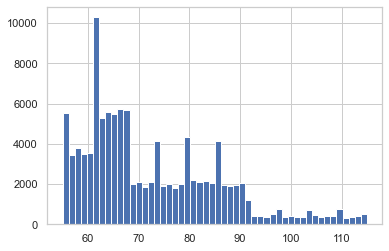

In [50]:
main.cust_tenure.hist(bins=50)

In [51]:
tenure_mean = main['cust_tenure'].mean()
main['cust_tenure'].fillna(value = tenure_mean, inplace=True)

In [52]:
main_ppl = main[['person_id','age','cust_tenure']].drop_duplicates()

In [53]:
main_ppl.head(10)

,person_id,age,cust_tenure
0,0009655768c64bdeb2e877511632db8f,33.000000,70
5,00116118485d4dfda04fdbaba9a87b5c,54.741604,58
9,0011e0d4e6b944f998e987f904e8c1e5,40.000000,61
14,0020c2b971eb4e9188eac86d93036a77,59.000000,84
19,0020ccbbb6d84e358d3414a3ff76cffd,24.000000,75
23,003d66b6608740288d6cc97a6903f4f0,26.000000,68
31,00426fe3ffde4c6b9cb9ad6d077a13ea,19.000000,78
36,004b041fbfe44859945daa2c7f79ee64,55.000000,57
39,004c5799adbf42868b9cff0396190900,54.000000,83
56,005500a7188546ff8a767329a2f7c76a,56.000000,62


In [54]:
col1, col2 = "age", "cust_tenure"
corr = main_ppl[col1].corr(main_ppl[col2])
print ("Correlation between ", col1, " and ", col2, "is: ", round(corr, 2))

Correlation between  age  and  cust_tenure is:  0.01


observation 5: cust_tenure and age are not correlated, so we may want to include both.

In [55]:
main.head(2)

,person_id,offer_id,time_rcv,time_view,time_cplt,if_view,if_complete,if_valid,gender,age,...,start_date,cust_tenure,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,0,1,0,M,33.0,...,2017-04-21,70,2,10,7,discount,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,1,0,0,M,33.0,...,2017-04-21,70,0,0,4,informational,1,1,1,0


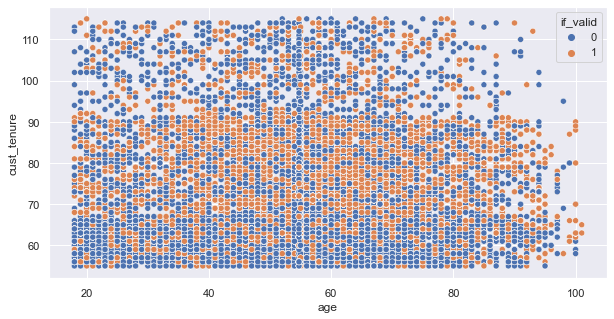

In [56]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = main.loc[main['offer_type']=='bogo', ['age','cust_tenure','if_valid']], x='age', y='cust_tenure', hue='if_valid')
plt.savefig('bogo_response_by_age.png',dpi = 300)

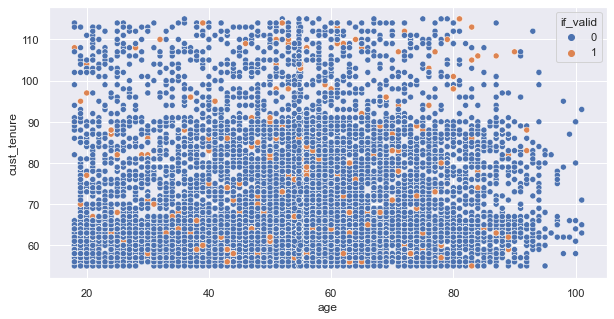

In [57]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = main.loc[main['offer_type']=='informational', ['age','cust_tenure','if_valid']], x='age', y='cust_tenure', hue='if_valid')
plt.savefig('informational_response_by_age.png',dpi = 300)

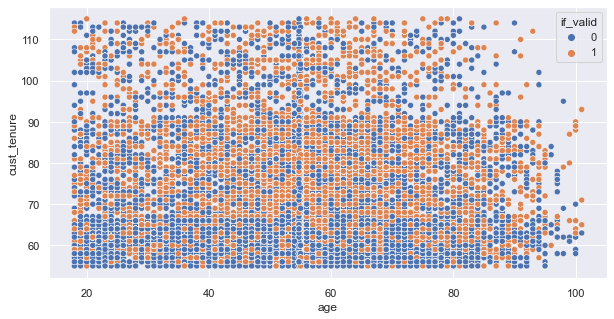

In [58]:
sns.set(rc={'figure.figsize':(10,5)})
sns.scatterplot(data = main.loc[main['offer_type']=='discount', ['age','cust_tenure','if_valid']], x='age', y='cust_tenure', hue='if_valid')
plt.savefig('discount_response_by_age.png',dpi = 300)

observation 6: there's no obvious trend of how age relates to whether a client would respond to an offer or not, but we can see clients with cust_tenure 60-90 months tend to respond more actively to BOGO and Discount offer. So it's a good idea to include 'cust_tenure' feature

In [59]:
main[['offer_type','difficulty']].groupby('offer_type').value_counts()

offer_type     difficulty
bogo           10            24206
               5             23327
discount       10            23579
               7             13520
               20             9026
informational  0             18673
dtype: int64

In [60]:
main[main['offer_type']!='informational'][['if_valid','difficulty','duration']].groupby('duration').mean()

,if_valid,difficulty
duration,,
5,0.458671,7.447687
7,0.418553,7.991215
10,0.404171,14.074208


observation 7: If the offer duration is longer, it's difficulty increases. However, people are not more likely to respond to an offer if the offer duration is longer.

# 3. Problem statement

Now we have a main table with cleaned, labeled data, we need a classification model to predict whether a client will respond to an offer

# 4. Classification model
#### 1. get the right features
    - from EDA, we want: gender, cust_tenure, offer_type
    -           we might also want age, difficulty, reward

In [61]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

random forest are robust to outliers and do not need variables to be normalized to work

In [62]:
main.head(2)

,person_id,offer_id,time_rcv,time_view,time_cplt,if_view,if_complete,if_valid,gender,age,...,start_date,cust_tenure,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,0,1,0,M,33.0,...,2017-04-21,70,2,10,7,discount,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,1,0,0,M,33.0,...,2017-04-21,70,0,0,4,informational,1,1,1,0


In [76]:
dummy_type = pd.get_dummies(main['offer_type'])
dummy_gender = pd.get_dummies(main['gender'])
main_model = pd.concat([main, dummy_type, dummy_gender], axis=1)

In [65]:
X = main_model[['age','cust_tenure','web','email','mobile','social','bogo','informational','discount','F','M','O','difficulty','reward','duration']] #model 1 input
y = main_model['if_valid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 2. use random forest as classifier

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [67]:
y_pred = rf.predict(X_test)

In [68]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7128232518805359
Precision: 0.6025165711717785
Recall: 0.6479400749063671


Hyperparameter Tuning via RandomizedSearchCV

In [69]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000011BD48BAB60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000011BDA51ADD0>})

In [70]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 113}


In [71]:
y_pred = best_rf.predict(X_test)

In [72]:
#model 1 output
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7252859749855344
Precision: 0.6177951874650252
Recall: 0.666908300108735


After adding feature: income

In [79]:
main_model[['income','if_valid']].groupby('if_valid').describe()

income                                                              \
            count          mean           std      min      25%           50%   
if_valid                                                                        
0         71323.0  64664.048700  19698.907155  30000.0  51000.0  66158.130473   
1         41008.0  68756.706222  20699.922946  30000.0  54000.0  67000.000000   

                             
              75%       max  
if_valid                     
0         74000.0  120000.0  
1         83000.0  120000.0

<AxesSubplot:>

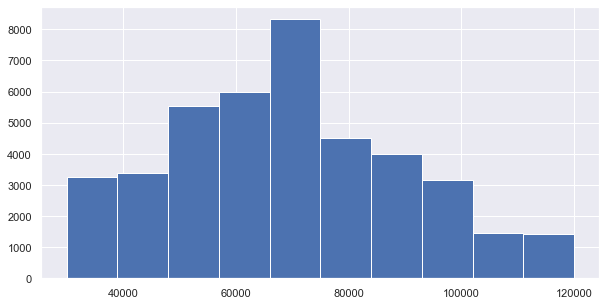

In [82]:
main_model[main_model['if_valid']==1]['income'].hist()

<AxesSubplot:>

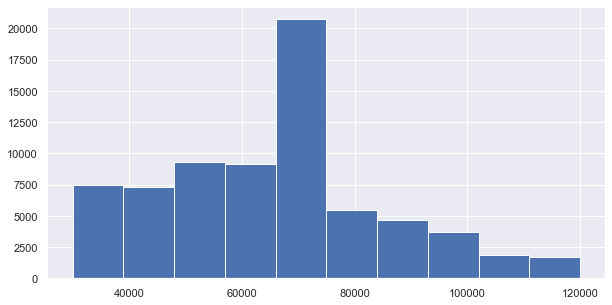

In [83]:
main_model[main_model['if_valid']==0]['income'].hist()

In [88]:
main_model.if_view.value_counts()

1    95895
0    16436
Name: if_view, dtype: int64

Try exlcude those if_view=0 from the dataset. Only care about whether customer react to an offer if he/she views the data

In [89]:
main_model_2 = main_model[main_model['if_view']==1]
main_model_2.shape

(95895, 27)

In [91]:
X = main_model_2[['age','cust_tenure', 'web','email','mobile','social','bogo','informational','discount','F','M','O','difficulty','reward','duration']] #model 2 input
y = main_model_2['if_valid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [92]:
X_train.shape

(76716, 15)

In [93]:
X_test.shape

(19179, 15)

In [94]:
y_train.shape

(76716,)

In [95]:
y_test.shape

(19179,)

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

In [96]:
y_pred = best_rf.predict(X_test)

In [97]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.7267323635226028
Precision: 0.6603671706263499
Recall: 0.7447326756789673


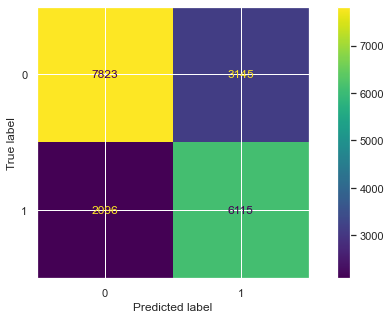

In [98]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()